In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals.joblib import dump
import time

#load data
print('Welcome! Let me work out what is the best experiment for you to run...')
#filename1 = input("Please type in your train data file name: ")
#filename2 = input('Please type in your chemical space file name: ')
print('\nStart:', time.strftime("%Y/%m/%d  %H:%M:%S"))
print('\nLoading: ', filename1)
filename1 = 'train_data.csv'
filename2 = 'all_combos.csv'
train = pd.read_csv(filename1)
array = train.values
X = array[:,1:-1]    
y = array[:,-1]


print('\nAll good till now. I am figuring out the best method to analyze your data. Bear with me...')
#General stuff
seed = 1234
kfold = KFold(n_splits = 10, random_state = seed) 
scoring = 'neg_mean_absolute_error'
model = RandomForestRegressor(random_state=seed)

#Parameters to tune
estimators = np.arange(100, 1050, 100) 
estimators_int = np.ndarray.tolist(estimators)
param_grid = {'n_estimators':estimators_int, 'max_features':['auto', 'sqrt'],
              'max_depth':[None,2]}

#search best parameters and train
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(X, y)

#print the best data cranked out from the grid search
np.savetxt('Model_best_score.txt', ["best_score: %s" % grid.best_score_], fmt ='%s')
best_params = pd.DataFrame([grid.best_params_], columns=grid.best_params_.keys())
best_params.to_csv('best_parameters.txt', sep= '\t')

print('\n... done! It is going to be lightspeed from here on out! :)')
#predict future data
# filename2 = 'all_comboss.csv'
df_all_combos = pd.read_csv(filename2, engine='python')
df_train_corrected = train.iloc[:,:-1]
unseen = pd.concat([df_all_combos, df_train_corrected]).drop_duplicates(keep=False)
array2 = unseen.values
X2 = array2[:,1:]
df_all_combos2 = df_all_combos.iloc[:,1:]

model2 = grid.best_estimator_
# model2 = RandomForestRegressor(n_estimators = grid.best_params_['n_estimators'], max_features = grid.best_params_['max_features'], max_depth = grid.best_params_['max_depth'], random_state = seed)
RF_fit = model2.fit(X, y)
predictions = model2.predict(X2)
predictions_df = pd.DataFrame(data=predictions, columns=['Prediction'])

#feature importance
feat_imp = pd.DataFrame(model2.feature_importances_,
                        index=train.drop(['Unnamed: 0', 'Yields'], axis=1).columns,
                        columns=['Feature_importances'])
feat_imp = feat_imp.sort_values(by=['Feature_importances'], ascending = False)

all_predictions = []
for e in model2.estimators_:
    all_predictions += [e.predict(X2)]

variance = np.var(all_predictions, axis=0)
variance_df = pd.DataFrame(data=variance, columns=['Variance'])

assert len(variance) == len(predictions)
initial_data = pd.DataFrame(data=array2, columns = list(unseen.columns.values))
df = pd.concat([initial_data, predictions_df, variance_df], axis=1)

#getting a list to organize sorting
feat_imp_T = feat_imp.transpose()
# feat_imp_T
keys1 = list(feat_imp_T.keys())
# keys1
keys2 = list(feat_imp_T.keys())
keys1.append('Prediction')
keys2.append( 'Variance')


#select the reaction (selecting for max everything)
df_sorted = df.sort_values(by=[keys1[-1], keys1[0]], ascending=[False, False])
preliminary = df_sorted.iloc[0:5]
df_sorted2 = preliminary.sort_values(by=[keys2[-1], keys2[0]], ascending=[True, False])
toPerform = df_sorted2.iloc[0]

#save data
feat_imp.to_csv('feature_importances.txt', sep= '\t')
toPerform.to_csv('selected_reaction.txt', sep = '\t', header=False)
df_sorted.to_csv('predictions.csv')
filename3 = 'random_forest_model_grid.sav'
dump(grid, filename3)


print('\nYou are all set! Have a good one, mate!')#all_comboss.csv
print('\nEnd:', time.strftime("%Y/%m/%d  %H:%M:%S"))#train_data.csv


Welcome! Let me work out what is the best experiment for you to run...

Start: 2019/09/11  16:16:44

Loading:  train_data.csv

All good till now. I am figuring out the best method to analyze your data. Bear with me...

... done! It is going to be lightspeed from here on out! :)


# Try to use re-shuffle and drop column on Labmate-ai

In [8]:
# defining rmse as scoring criteria (any other criteria can be used in a similar manner)

def score(x1,x2):
    return metrics.mean_absolute_error(x1,x2)
# defining feature importance function based on above logic
def feat_imp(m, x, y, small_good = True):
    
# """
# m: random forest model
# x: matrix of independent variables
# y: output variable
# small__good: True if smaller prediction score is better
# """
    score_list = {} 
    score_list['original'] = score(m.predict(x.values), y) 
    imp = {} 
    for i in range(len(x.columns)): 
        rand_idx = np.random.permutation(len(x)) # randomization
        new_coli = x.values[rand_idx, i] 
        new_x = x.copy()            
        new_x[x.columns[i]] = new_coli 
        score_list[x.columns[i]] = score(m.predict(new_x.values), y) 
        imp[x.columns[i]] = score_list['original']-score_list[x.columns[i]] # comparison with benchmark
    if small_good:
        return sorted(imp.items(), key=lambda x: x[1]) 
    else: return sorted(imp.items(), key=lambda x: x[1], reverse=True)
    
from sklearn import metrics
X = train.iloc[:,1:-1] 
y = train.iloc[:,-1]
importance = feat_imp(model2, X, y)
importance

[('base (equiv.)', -2.781185303359429),
 ('Cat (mol%)', -1.7043195051763342),
 ('i_PrOH (equiv)', -1.1031627717408246),
 ('Time (Hrs)', -0.6463229802400254),
 ('Ligan2Metal', -0.605653286201439),
 ('2meth (mmol)', -0.5366955580237105),
 ('Temperature (C)', -0.3005129312953876),
 ('concentration (M)', -0.2674401420930004),
 ('nap (mmol)', 0.0)]

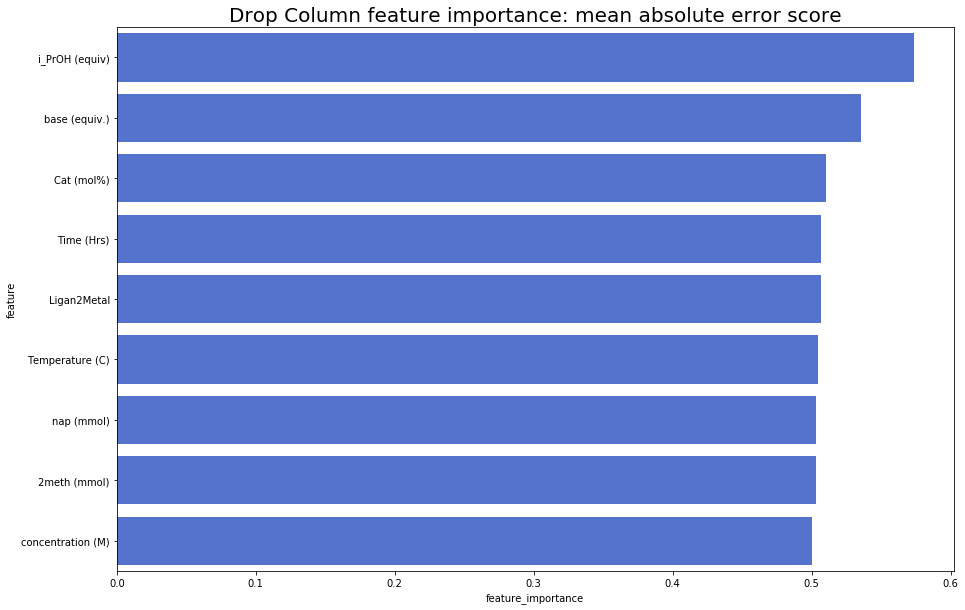

In [9]:
from sklearn.base import clone
import seaborn as sns
import sklearn.metrics as metrics

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    y_pred = model_clone.predict(X_train)
    benchmark_score = metrics.mean_absolute_error(y_train, y_pred) #benckmark是r^2分
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)
  
drop_imp = drop_col_feat_imp(model2, X, y)
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
var_imp_plot(drop_imp, 'Drop Column feature importance: mean absolute error score')
plt.show() 

# Tree interpreter

In [78]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals.joblib import dump
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#load data
print('Welcome! Let me work out what is the best experiment for you to run...')
#filename1 = input("Please type in your train data file name: ")
#filename2 = input('Please type in your chemical space file name: ')
print('\nStart:', time.strftime("%Y/%m/%d  %H:%M:%S"))
print('\nLoading: ', filename1)
filename1 = 'train_data.csv'
# filename2 = 'all_combos.csv'
seed = 1
train = pd.read_csv(filename1)
X, y = shuffle(train.drop(['Unnamed: 0','Yields'], axis=1), train['Yields'],random_state = seed) 
X_train, X_test,y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = seed) 

model2 = RandomForestRegressor(n_estimators = 100, 
                               max_features ='auto', max_depth =2, random_state = seed)
model2.fit(X_train, y_train)

Welcome! Let me work out what is the best experiment for you to run...

Start: 2019/09/11  17:26:18

Loading:  train_data.csv


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [79]:
from treeinterpreter import treeinterpreter as ti
filename1 = 'train_data.csv'
filename2 = 'all_combos.csv'
df = pd.read_csv(filename1)
X_train = df.iloc[:, 1:-1]
y_train = df.iloc[:, -1]

selected_rows = list(X_test.index)
selected_df = X_test.values
prediction, bias, contributions = ti.predict(model2, selected_df)
# len(X_test.index)
for i in range(len(selected_rows)):
#     print("Row", selected_rows[i])
#     print("Prediction:", prediction[i], 'Actual Value:', y_train[selected_rows[i]])
#     print("Bias (trainset mean)", bias[i])
#     print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 X_train.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20)
    
contributions1 = pd.DataFrame(contributions, columns=X_train.columns )
contributions1

base (equiv.) -5.5
Cat (mol%) 0.87
i_PrOH (equiv) -0.58
Temperature (C) -0.29
2meth (mmol) 0.09
Time (Hrs) 0.08
concentration (M) 0.06
Ligan2Metal -0.05
nap (mmol) 0.0
--------------------
base (equiv.) -4.24
Cat (mol%) -1.84
Ligan2Metal -0.24
i_PrOH (equiv) -0.22
Temperature (C) 0.13
concentration (M) 0.09
2meth (mmol) 0.08
Time (Hrs) -0.01
nap (mmol) 0.0
--------------------
base (equiv.) 2.1
Ligan2Metal 1.85
Cat (mol%) 1.53
i_PrOH (equiv) -1.08
Temperature (C) 0.35
concentration (M) 0.06
Time (Hrs) -0.05
nap (mmol) 0.0
2meth (mmol) 0.0
--------------------
base (equiv.) -5.89
Cat (mol%) 0.9
Temperature (C) 0.3
i_PrOH (equiv) -0.27
Ligan2Metal 0.18
concentration (M) -0.1
Time (Hrs) -0.07
2meth (mmol) 0.02
nap (mmol) 0.0
--------------------
base (equiv.) 2.52
Ligan2Metal 1.84
Cat (mol%) 1.37
i_PrOH (equiv) 0.37
Temperature (C) -0.32
concentration (M) 0.06
Time (Hrs) -0.01
nap (mmol) 0.0
2meth (mmol) 0.0
--------------------
base (equiv.) 2.25
Cat (mol%) -2.09
Ligan2Metal 1.88
i_PrOH 

,nap (mmol),2meth (mmol),Ligan2Metal,Cat (mol%),base (equiv.),i_PrOH (equiv),Time (Hrs),Temperature (C),concentration (M)
0,0.0,0.089737,-0.048417,0.874691,-5.504043,-0.583489,0.080282,-0.285673,0.058009
1,0.0,0.076404,-0.239437,-1.843792,-4.240881,-0.217953,-0.012842,0.125308,0.092139
2,0.0,0.000000,1.851859,1.526787,2.099931,-1.077741,-0.047777,0.353068,0.057604
3,0.0,0.019359,0.180715,0.897752,-5.894837,-0.265355,-0.065080,0.297901,-0.095106
4,0.0,0.000000,1.838866,1.368045,2.523708,0.374417,-0.009125,-0.323985,0.057604
5,0.0,0.010666,1.882183,-2.087237,2.245629,0.432294,-0.021268,0.145111,0.091735
6,0.0,0.000000,1.738822,1.429260,2.532947,1.125168,-0.009125,0.368216,-0.093606
7,0.0,0.000845,-3.373941,-1.991854,2.173519,0.421818,0.090827,0.090107,0.091735
8,0.0,0.000845,-3.392132,-2.087237,1.783966,0.983719,-0.140901,0.103217,0.091735


<IPython.core.display.Javascript object>


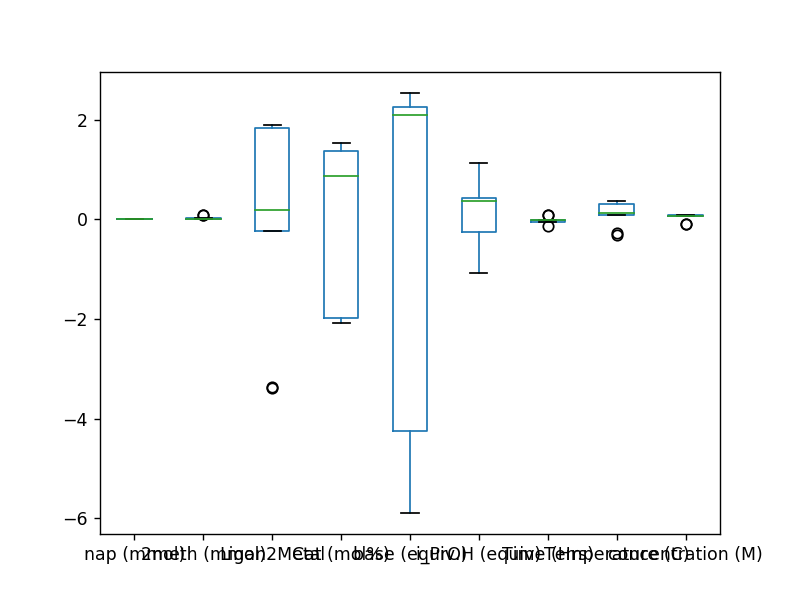

In [80]:
%matplotlib notebook
# plt.figure(figsize=(10,10))
contributions1.plot.box()
# plt.show()

# seed = 2

Welcome! Let me work out what is the best experiment for you to run...

Start: 2019/09/11  17:26:52

Loading:  train_data.csv
Cat (mol%) -1.51
i_PrOH (equiv) -1.36
base (equiv.) -1.27
Ligan2Metal -0.86
2meth (mmol) -0.16
concentration (M) -0.09
Temperature (C) -0.08
Time (Hrs) 0.03
nap (mmol) 0.0
--------------------
base (equiv.) -3.9
i_PrOH (equiv) -0.93
Cat (mol%) 0.73
Ligan2Metal 0.61
2meth (mmol) -0.11
Time (Hrs) 0.09
concentration (M) 0.07
Temperature (C) -0.06
nap (mmol) 0.0
--------------------
base (equiv.) -3.89
i_PrOH (equiv) -0.92
Cat (mol%) 0.78
Ligan2Metal 0.68
Time (Hrs) 0.1
2meth (mmol) 0.06
Temperature (C) -0.06
concentration (M) -0.05
nap (mmol) 0.0
--------------------
i_PrOH (equiv) 2.06
base (equiv.) 0.75
Ligan2Metal 0.58
2meth (mmol) 0.08
Cat (mol%) -0.03
Time (Hrs) -0.01
concentration (M) -0.01
Temperature (C) 0.0
nap (mmol) 0.0
--------------------
Cat (mol%) -2.28
Ligan2Metal -1.34
base (equiv.) 0.86
i_PrOH (equiv) -0.16
Temperature (C) -0.11
2meth (mmol) 0.09


<IPython.core.display.Javascript object>


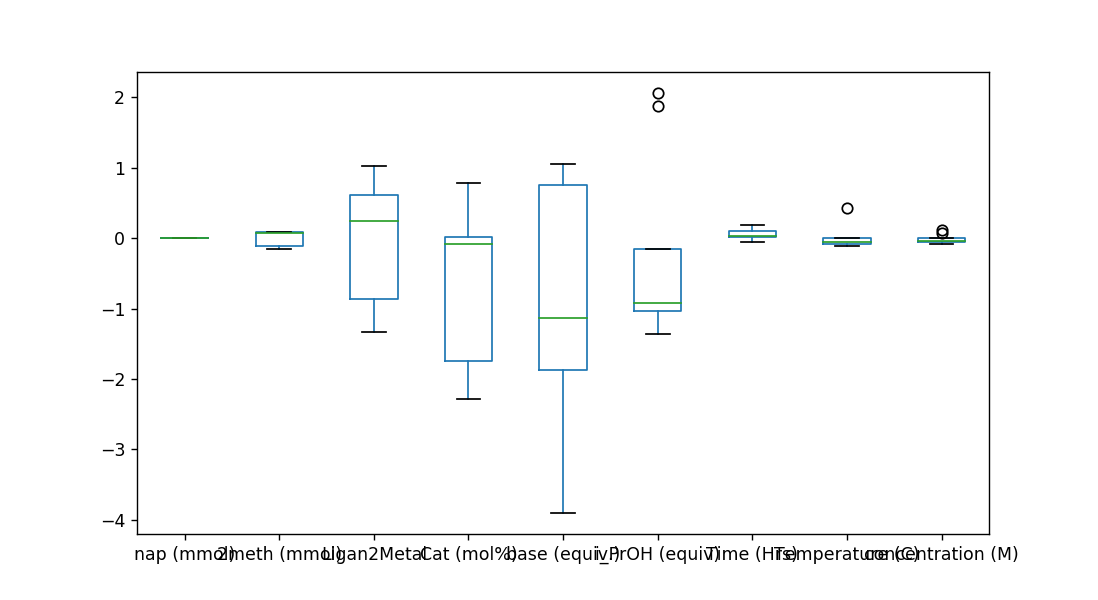

In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals.joblib import dump
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#load data
print('Welcome! Let me work out what is the best experiment for you to run...')
#filename1 = input("Please type in your train data file name: ")
#filename2 = input('Please type in your chemical space file name: ')
print('\nStart:', time.strftime("%Y/%m/%d  %H:%M:%S"))
print('\nLoading: ', filename1)
filename1 = 'train_data.csv'
# filename2 = 'all_combos.csv'
seed = 2
train = pd.read_csv(filename1)
X, y = shuffle(train.drop(['Unnamed: 0','Yields'], axis=1), train['Yields'],random_state = seed) 
X_train, X_test,y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = seed) 

model2 = RandomForestRegressor(n_estimators = 100, 
                               max_features ='auto', max_depth =2, random_state = seed)
model2.fit(X_train, y_train)

from treeinterpreter import treeinterpreter as ti
filename1 = 'train_data.csv'
filename2 = 'all_combos.csv'
df = pd.read_csv(filename1)
X_train = df.iloc[:, 1:-1]
y_train = df.iloc[:, -1]

selected_rows = list(X_test.index)
selected_df = X_test.values
prediction, bias, contributions = ti.predict(model2, selected_df)
# len(X_test.index)
for i in range(len(selected_rows)):
#     print("Row", selected_rows[i])
#     print("Prediction:", prediction[i], 'Actual Value:', y_train[selected_rows[i]])
#     print("Bias (trainset mean)", bias[i])
#     print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 X_train.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20) 
    
contributions1 = pd.DataFrame(contributions, columns=X_train.columns)

%matplotlib notebook
# plt.figure(figsize=(10,10))
contributions1.plot.box()
# plt.show()

Welcome! Let me work out what is the best experiment for you to run...

Start: 2019/09/11  17:35:53

Loading:  train_data.csv
Cat (mol%) -1.46
Ligan2Metal 1.11
base (equiv.) 0.99
i_PrOH (equiv) -0.67
concentration (M) 0.1
Temperature (C) 0.08
Time (Hrs) 0.02
2meth (mmol) 0.01
nap (mmol) 0.0
--------------------
base (equiv.) 1.04
i_PrOH (equiv) -0.75
Time (Hrs) -0.5
Ligan2Metal 0.42
Cat (mol%) 0.18
Temperature (C) 0.17
concentration (M) -0.17
2meth (mmol) -0.01
nap (mmol) 0.0
--------------------
base (equiv.) 2.05
Cat (mol%) 1.72
Ligan2Metal 1.04
Time (Hrs) 0.98
i_PrOH (equiv) 0.89
concentration (M) 0.18
Temperature (C) -0.08
nap (mmol) 0.0
2meth (mmol) 0.0
--------------------
base (equiv.) -2.14
Cat (mol%) -1.17
Ligan2Metal -0.96
i_PrOH (equiv) 0.87
Time (Hrs) 0.56
concentration (M) 0.32
Temperature (C) -0.02
2meth (mmol) -0.0
nap (mmol) 0.0
--------------------
base (equiv.) -2.78
Cat (mol%) -1.07
i_PrOH (equiv) -0.6
Ligan2Metal 0.4
Time (Hrs) 0.1
concentration (M) 0.09
2meth (mmol

<IPython.core.display.Javascript object>


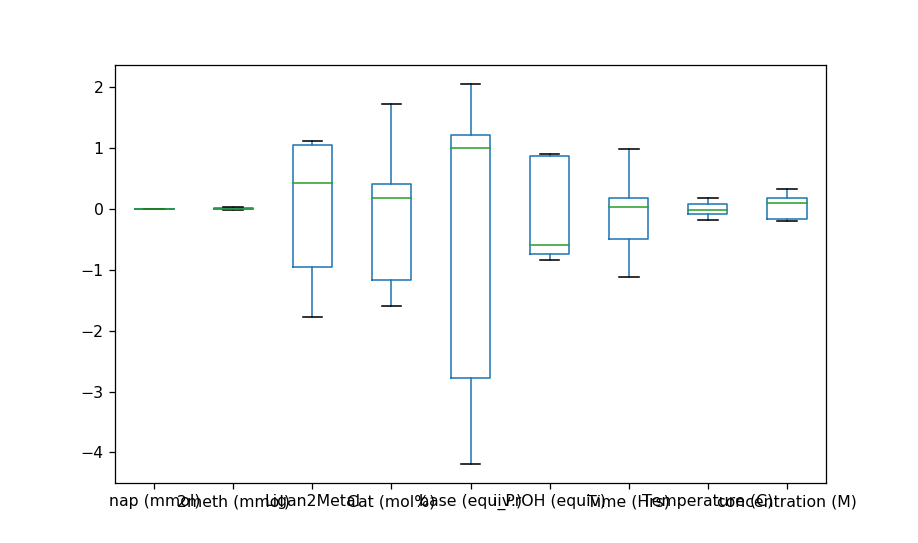

In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals.joblib import dump
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#load data
print('Welcome! Let me work out what is the best experiment for you to run...')
#filename1 = input("Please type in your train data file name: ")
#filename2 = input('Please type in your chemical space file name: ')
print('\nStart:', time.strftime("%Y/%m/%d  %H:%M:%S"))
print('\nLoading: ', filename1)
filename1 = 'train_data.csv'
# filename2 = 'all_combos.csv'
seed = 4
train = pd.read_csv(filename1)
X, y = shuffle(train.drop(['Unnamed: 0','Yields'], axis=1), train['Yields'],random_state = seed) 
X_train, X_test,y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = seed) 

model2 = RandomForestRegressor(n_estimators = 100, 
                               max_features ='auto', max_depth =2, random_state = seed)
model2.fit(X_train, y_train)

from treeinterpreter import treeinterpreter as ti
filename1 = 'train_data.csv'
filename2 = 'all_combos.csv'
df = pd.read_csv(filename1)
X_train = df.iloc[:, 1:-1]
y_train = df.iloc[:, -1]

selected_rows = list(X_test.index)
selected_df = X_test.values
prediction, bias, contributions = ti.predict(model2, selected_df)
# len(X_test.index)
for i in range(len(selected_rows)):
#     print("Row", selected_rows[i])
#     print("Prediction:", prediction[i], 'Actual Value:', y_train[selected_rows[i]])
#     print("Bias (trainset mean)", bias[i])
#     print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 X_train.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20) 
    
contributions1 = pd.DataFrame(contributions, columns=X_train.columns)

%matplotlib notebook
# plt.figure(figsize=(10,10))
contributions1.plot.box()
# plt.show()

<IPython.core.display.Javascript object>


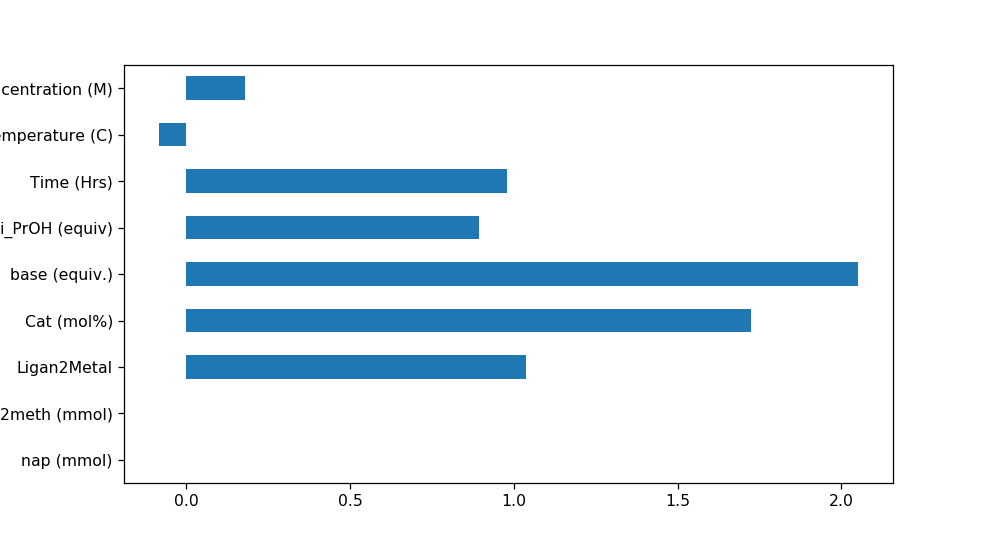

In [92]:
%matplotlib notebook
contributions1.iloc[2,:].plot.barh()
plt.show()